# Prototype model for Austin

This is a play model that I'm gonna create for detecting "outliers" precincts in the amount of incidents that ocurred with it.

Hopefully, I will discover things here and it may also provide some nice visuals.

## The plan

Initially, we have data for:

- Population demographics (census tracts)
- Incidents victims (+ demographics) (granular)
- Crimes (granular, no demographics)

First, I thought that we could make a really simple model, calculating number of incidents per crime, for each race category.

This will not be possible, though, since crime data has no race information. So, instead, we will focus on the region level (which has race data). (1)

To focus on the region level, we had two choices, focusing on the *census tracts* or, focusing on the *police districts* (there are also some more options, like focus on pollice stations, aggregates of districts, etc).

(1): Might be useful for police stations to *record information of the race* when crimes happen (and are recorded, of course)

### Focusing on census tracts

I feel like this would provide valuable information for police stations. Like, where are the most problematic regions? And, it would also be super simple to create a modek like this, since we don't need to resample (the information is already there).

But, since the CPE asked specifically for the problem of merging census data with precinct boundaries, I believe that using police districts as boundaries may provide a better use for them, and this is what I'm gonna do.

### Focusing on police districts

To focus on police districts, beforec any data conversion goes on, we need to perform a resampling of the census tracts data. That is, given the data retrieved in the census, can we move this into new areas, the police districts?

*This is probably a well-known problem*. So, we might want to search later of possibles ways of doing this.

By now, we will stick to the simplest and consider each census tract has a constant density. We will also forget about possible errors coming from the data or being generated in the resampling process and the model.

## The objective

If the plan goes as thought out, I ideally want to generate map outputs. This map will contain the boundaries for police precincts and, for each precinct, there will be a value indicating how far the percentage of incidents is from what would be expected in a society that is essentially color-blind.

The objective is a bit far-fetched yet, but, as the prototype progresses, I think it will become clearer.

Along the way (specially at the end of phase 1), we will also be able to generate plots indicating population statistcs of each police precinct. This will be a nice way of visually checking the resampling results and also a showcase for it (the challenge might be done like this).


## So, let's go!

# Prepare

At this stage, let's prepare everything for phase one.

*steps here may be automated in preprocessing stage*

In [1]:
# imports

from collections import defaultdict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shapely.ops import cascaded_union

In [2]:
# config

%matplotlib inline

pd.options.display.max_colwidth = 500

## American Community Survey

This is the census.

All variables here will be used as a control (that is, they will be usual explanatory variables in our model).

In [3]:
!tree ../../data/raw/cpe-data/Dept_37-00027/37-00027_ACS_data/

../../data/raw/cpe-data/Dept_37-00027/37-00027_ACS_data/
├── 37-00027_ACS_education-attainment
│   ├── ACS_16_5YR_S1501_metadata.csv
│   └── ACS_16_5YR_S1501_with_ann.csv
├── 37-00027_ACS_education-attainment-over-25
│   ├── ACS_16_5YR_B15003_metadata.csv
│   └── ACS_16_5YR_B15003_with_ann.csv
├── 37-00027_ACS_owner-occupied-housing
│   ├── ACS_16_5YR_S2502_metadata.csv
│   └── ACS_16_5YR_S2502_with_ann.csv
├── 37-00027_ACS_poverty
│   ├── ACS_16_5YR_S1701_metadata.csv
│   └── ACS_16_5YR_S1701_with_ann.csv
├── 37-00027_ACS_race-sex-age
│   ├── ACS_15_5YR_DP05_metadata.csv
│   ├── ACS_15_5YR_DP05.txt
│   ├── ACS_15_5YR_DP05_with_ann.csv
│   └── aff_download_readme_ann.txt
└── _DS_Store

5 directories, 13 files


### Little simplification

Since there are lots of census data variables and stuff, discovering the adequate properties we should use in each one is a bit of timely thing. So, intead of using lots of things for control, let's choose just the crimes and poverty. I believe this will already give a good challenge and let me thinking where things could be automated already.

### Load demographics data

In [4]:
path = '../../data/raw/cpe-data/Dept_37-00027/37-00027_ACS_data/37-00027_ACS_race-sex-age/ACS_15_5YR_DP05_with_ann.csv'
demographics = pd.read_csv(path, header=0, skiprows=[1])
demographics = demographics.set_index('GEO.id2')
demographics_names = pd.read_csv(path, header=0, nrows=1).loc[0]

In [5]:
demographics.head()

GEO.id                        GEO.display-label  \
GEO.id2                                                                      
48453000101  1400000US48453000101  Census Tract 1.01, Travis County, Texas   
48453000102  1400000US48453000102  Census Tract 1.02, Travis County, Texas   
48453000203  1400000US48453000203  Census Tract 2.03, Travis County, Texas   
48453000204  1400000US48453000204  Census Tract 2.04, Travis County, Texas   
48453000205  1400000US48453000205  Census Tract 2.05, Travis County, Texas   

             HC01_VC03  HC02_VC03  HC03_VC03 HC04_VC03  HC01_VC04  HC02_VC04  \
GEO.id2                                                                        
48453000101       4061        288       4061       (X)       1889        237   
48453000102       2556        195       2556       (X)       1176        157   
48453000203       1460        166       1460       (X)        608         93   
48453000204       3092        213       3092       (X)       1567        156   
48453000205       4154        474       4154       (X)       2473        468   

            HC03_VC04 HC04_VC04     ...      HC03_VC108  HC04_VC108  \
GEO.id2                             ...                               
48453000101      46.5       3.7     ...            3284         (X)   
48453000102      46.0       4.6     ...            1966         (X)   
48453000203      41.6       5.2     ...            1143         (X)   
48453000204      50.7       5.0     ...            2533         (X)   
48453000205      59.5       6.1     ...            3305         (X)   

            HC01_VC109 HC02_VC109  HC03_VC109  HC04_VC109 HC01_VC110  \
GEO.id2                                                                
48453000101       1469        203        44.7         3.7       1815   
48453000102        946        127        48.1         5.1       1020   
48453000203        467         88        40.9         5.9        676   
48453000204       1337        160        52.8         5.8       1196   
48453000205       2023        404        61.2         6.1       1282   

            HC02_VC110  HC03_VC110  HC04_VC110  
GEO.id2                                         
48453000101        141        55.3         3.7  
48453000102        122        51.9         5.1  
48453000203        120        59.1         5.9  
48453000204        203        47.2         5.8  
48453000205        163        38.8         6.1  

[5 rows x 338 columns]

### Load poverty data

In [6]:
path = '../../data/raw/cpe-data/Dept_37-00027/37-00027_ACS_data/37-00027_ACS_poverty/ACS_16_5YR_S1701_with_ann.csv'
poverty = pd.read_csv(path, header=0, skiprows=[1])
poverty = poverty.set_index('GEO.id2')
poverty_names = pd.read_csv(path, header=0, nrows=1).loc[0]

In [7]:
poverty.head()

GEO.id                        GEO.display-label  \
GEO.id2                                                                      
48453000101  1400000US48453000101  Census Tract 1.01, Travis County, Texas   
48453000102  1400000US48453000102  Census Tract 1.02, Travis County, Texas   
48453000203  1400000US48453000203  Census Tract 2.03, Travis County, Texas   
48453000204  1400000US48453000204  Census Tract 2.04, Travis County, Texas   
48453000205  1400000US48453000205  Census Tract 2.05, Travis County, Texas   

             HC01_EST_VC01  HC01_MOE_VC01  HC02_EST_VC01  HC02_MOE_VC01  \
GEO.id2                                                                   
48453000101           4270            276            270            104   
48453000102           2570            171             81             74   
48453000203           1258            174            423            142   
48453000204           3042            199            589            171   
48453000205           4227            425            547            325   

            HC03_EST_VC01 HC03_MOE_VC01  HC01_EST_VC03  HC01_MOE_VC03  \
GEO.id2                                                                 
48453000101           6.3           2.4            821            133   
48453000102           3.2           2.9            571             79   
48453000203          33.6           9.1             49             40   
48453000204          19.4           5.7            426             68   
48453000205          12.9           6.7            478            160   

                 ...       HC02_EST_VC78  HC02_MOE_VC78 HC03_EST_VC78  \
GEO.id2          ...                                                    
48453000101      ...                 127             66          30.6   
48453000102      ...                   4              5           2.5   
48453000203      ...                 169             73          49.9   
48453000204      ...                 341            137          55.8   
48453000205      ...                 302            221          41.4   

            HC03_MOE_VC78  HC01_EST_VC79  HC01_MOE_VC79  HC02_EST_VC79  \
GEO.id2                                                                  
48453000101          16.4            420             99            117   
48453000102           3.2            255             72             43   
48453000203          13.2            207             96            160   
48453000204          14.7            244             91            168   
48453000205          21.6            311            163            205   

             HC02_MOE_VC79 HC03_EST_VC79 HC03_MOE_VC79  
GEO.id2                                                 
48453000101             65          27.9          14.2  
48453000102             32          16.9          11.4  
48453000203             90          77.3          15.7  
48453000204             80          68.9          17.5  
48453000205            141          65.9          28.9  

[5 rows x 368 columns]

In [8]:
poverty_names.to_frame().T

GEO.id GEO.id2 GEO.display-label  \
0     Id     Id2         Geography   

                                                       HC01_EST_VC01  \
0  Total; Estimate; Population for whom poverty status is determined   

                                                              HC01_MOE_VC01  \
0  Total; Margin of Error; Population for whom poverty status is determined   

                                                                     HC02_EST_VC01  \
0  Below poverty level; Estimate; Population for whom poverty status is determined   

                                                                            HC02_MOE_VC01  \
0  Below poverty level; Margin of Error; Population for whom poverty status is determined   

                                                                             HC03_EST_VC01  \
0  Percent below poverty level; Estimate; Population for whom poverty status is determined   

                                                                                    HC03_MOE_VC01  \
0  Percent below poverty level; Margin of Error; Population for whom poverty status is determined   

                           HC01_EST_VC03  \
0  Total; Estimate; AGE - Under 18 years   

                              ...                              \
0                             ...                               

                                                                                 HC02_EST_VC78  \
0  Below poverty level; Estimate; Worked less than full-time, year-round in the past 12 months   

                                                                                        HC02_MOE_VC78  \
0  Below poverty level; Margin of Error; Worked less than full-time, year-round in the past 12 months   

                                                                                         HC03_EST_VC78  \
0  Percent below poverty level; Estimate; Worked less than full-time, year-round in the past 12 months   

                                                                                                HC03_MOE_VC78  \
0  Percent below poverty level; Margin of Error; Worked less than full-time, year-round in the past 12 months   

                   HC01_EST_VC79                         HC01_MOE_VC79  \
0  Total; Estimate; Did not work  Total; Margin of Error; Did not work   

                                 HC02_EST_VC79  \
0  Below poverty level; Estimate; Did not work   

                                        HC02_MOE_VC79  \
0  Below poverty level; Margin of Error; Did not work   

                                         HC03_EST_VC79  \
0  Percent below poverty level; Estimate; Did not work   

                                                HC03_MOE_VC79  
0  Percent below poverty level; Margin of Error; Did not work  

[1 rows x 369 columns]

### Load spatial coordinates

To load the geographic coordinates, we will use geopandas.

In [9]:
path = '../../data/raw/census_tx/'
census = gpd.read_file(path)
census = census.set_index('GEOID')

In [10]:
census.head()

STATEFP COUNTYFP TRACTCE     NAME              NAMELSAD  MTFCC  \
GEOID                                                                        
48201542301      48      201  542301  5423.01  Census Tract 5423.01  G5020   
48157673800      48      157  673800     6738     Census Tract 6738  G5020   
48157674000      48      157  674000     6740     Census Tract 6740  G5020   
48157674100      48      157  674100     6741     Census Tract 6741  G5020   
48201552601      48      201  552601  5526.01  Census Tract 5526.01  G5020   

            FUNCSTAT     ALAND   AWATER     INTPTLAT      INTPTLON  \
GEOID                                                                
48201542301        S   5956745    15456  +29.8204990  -095.7316493   
48157673800        S  14100074  1008190  +29.5874575  -095.7125243   
48157674000        S   4826110    65291  +29.5869509  -095.6224534   
48157674100        S   4170610        0  +29.5791692  -095.5995891   
48201552601        S   2911911     4263  +29.9629845  -095.5679180   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
GEOID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
48201542301  POLYGON ((-95.75223799999999 29.831686, -95.751042 29.831706, -95.75047599999999 29.831716, -95.75031899999999 29.831719, -95.750129 29.831712, -95.74956399999999 29.831718, -95.749382 29.831732, -95.749195 29.831737, -95.749004 29.831729, -95.74835899999999 29.831741, -95.74789299999999 29.831751, -95.745707 29.831771, -95.74041899999999 29.831817, -95.74027199999999 29.831813, -95.740127 29.831801, -95.739986 29.831784, -95.73965799999999 29.831584, -95.73949399999999 29.831485, -95.738884...  
48157673800  POLYGON ((-95.758386 29.583531, -95.757993 29.583762, -95.757818 29.583859, -95.75702799999999 29.58433, -95.756602 29.584575, -95.75624599999999 29.584714, -95.75571599999999 29.584922, -95.755314 29.585022, -95.754993 29.585129, -95.75470799999999 29.585199, -95.753884 29.58546, -95.75350499999999 29.585021, -95.75337599999999 29.585094, -95.753321 29.585126, -95.753298 29.585138, -95.753005 29.585309, -95.75254099999999 29.585564, -95.752499 29.585593, -95.75207999999999 29.585885, -95.75...  
48157674000  POLYGON ((-95.63467299999999 29.589525, -95.63450899999999 29.589627, -95.633906 29.590003, -95.63287 29.59065, -95.631193 29.591697, -95.630487 29.592155, -95.629705 29.592663, -95.62887599999999 29.593202, -95.628624 29.593365, -95.62718699999999 29.59437, -95.626268 29.595116, -95.625812 29.595503, -95.625326 29.595961, -95.623475 29.597571, -95.62280799999999 29.598258, -95.622715 29.598354, -95.62255399999999 29.59852, -95.622514 29.598555, -95.622259 29.598414, -95.621864 29.598273, -9...  
48157674100  POLYGON ((-95.614667 29.578282, -95.61338599999999 29.578862, -95.61306999999999 29.578967, -95.61277 29.579077, -95.61242299999999 29.579323, -95.61216499999999 29.579513, -95.611724 29.579875, -95.611459 29.580196, -95.61138699999999 29.580283, -95.611313 29.580361, -95.61122399999999 29.580456, -95.61085399999999 29.580941, -95.61044099999999 29.581357, -95.61005 29.58178, -95.609

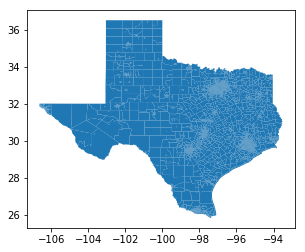

In [11]:
census.plot()

## Police data

Here we load the Police Districts Shapefile, crimes data and incidents data.

In [12]:
path = '../../data/raw/cpe-data/Dept_37-00027/37-00027_Shapefiles/'
districts = gpd.read_file(path)  # there's no projection information

In [13]:
districts.shape

# 53 police districts

(53, 20)

In [14]:
districts.head()

NAME  SORTORDER  BATID  JURIID       COLOR  CODE EXTERNALKE  \
0  CHARLIE 4        1.0  400.0    11.0  16744576.0  1282       1282   
1   GEORGE 1        1.0  194.0    15.0  16744576.0  1298       1298   
2   GEORGE 2        1.0  194.0    15.0  16776960.0  1297       1297   
3      IDA 1        1.0  215.0    60.0  16744576.0  1307       1307   
4      IDA 2        1.0  215.0    60.0  16711680.0  1304       1304   

  BATTALIONC   DISTRICT   SECTOR  INPUT_DATE MODIFIED_D       INPUT_BY  \
0       CHAR  CHARLIE 4  CHARLIE  2014-12-22       None  bmartinlimuel   
1         G1   GEORGE 1   GEORGE  2014-12-22       None  bmartinlimuel   
2         G1   GEORGE 2   GEORGE  2014-12-22       None  bmartinlimuel   
3         I1      IDA 1      IDA  2014-12-22       None  bmartinlimuel   
4         I1      IDA 2      IDA  2014-12-22       None  bmartinlimuel   

  MODIFIED_B   BUREAU    PATROL_ARE    AREACOMMAN    SHAPE_AREA  \
0       None  CENTRAL   CENTRALEAST  512-974-5900  6.657440e+08   
1       None    NORTH          DTAC  512-974-5203  2.790690e+07   
2       None    NORTH          DTAC  512-974-5203  9.667245e+06   
3       None  CENTRAL  NORTHCENTRAL  512-974-5203  1.054603e+08   
4       None  CENTRAL  NORTHCENTRAL  512-974-5203  6.245594e+07   

       SHAPE_LEN  \
0  387953.791071   
1   23590.887752   
2   19773.819675   
3   48972.544807   
4   38742.443899   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              geometry  
0  POLYGON ((3160030.801874995 10110945.26125, 3160134.913749993 10110890.71625, 3160182.493125007 10110865.78, 3160183.113749996 10110865.45375, 3160183.989374995 10110864.99625, 3160205.892499998 10110853.55374999, 3160210.040625006 10110851.345, 3160216.353750005 10110848.03625, 3160236.224999994 10110837.721875, 3160255.118125007 10110827.791875, 3160261.246875003 10110824.596875, 3160264.065624997 10110823.03812499, 3160271.497500002 10110819.223125, 3160362.927499995 10110771.30125, 31603...  
1  POLYGON ((3117569.753749996 10072205.20874999, 3117563.676874995 10072184.921875, 3117431.386875004 10071739.031875, 3117417.806875005 10071693.63187499, 3117416.556875005 10071690.311875, 3117451.246875003 10071680.001875, 3117474.506874993 10071673.091875, 3117503.626874998 10071665.201875, 3117552.506874993 10071651.99187499, 3117867.496875003 10071550.001875, 3118068.756874993 10071466.621875, 3118077.496875003 10071463.001875, 3118282.496875003 10071381.001875, 3118497.676874995 1007129...  
2  POLYGON ((3117394.076875001 10072195.676875, 3117388.046875 10072175.611875, 3117365.976875007 10072108.21187501, 3117321.516874999 10071954.151875, 3117315.846874997 10071934.60187501, 3117271.976875007 10071783.451875, 3117271.876874998 10071783.151875, 3117271.796875 10071782.861875, 3117257.886875004 10071740.52187499, 3117243.686875001 10071692.511875, 3117173.206874996 10071455.421875, 3117155.226875007 10071394.891875, 3117147.296875 10071364.751875, 3117110.616874993 10071240.451875,...  
3  POLYGON ((3138058.366874993 10093095.421875, 3138042.896874994 10093090.45999999, 3138031.643749997 10093086.82187501, 3138012.614999995 10093080.66500001, 3137989.534999996 10093073.205625, 3137989.208124995 10093073.098125, 3137809.805625007 10093015.30562501, 3137809.389375001 10093015.16500001, 3137754.635000005 10092997.50687499, 3137751.153750002 10092996.386875, 3137747.678124994 10092995.268125, 3137612.239999995 10092951.57875, 3137598.403750002 10092946.41187499, 3137389.203749999 ...  
4  POLYGON ((3132516.318124995 10096385.60124999, 3132393.525000006 10096156.481875, 31

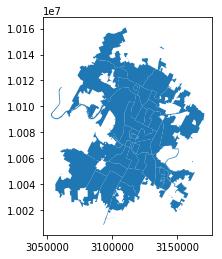

In [15]:
districts.plot()

In [16]:
crimes = pd.read_csv('../../data/raw/crime_reports_austin.csv')
crimes['Occurred Date Time'] = pd.to_datetime(crimes['Occurred Date Time'])
crimes['Clearance Date'] = pd.to_datetime(crimes['Clearance Date'])

In [17]:
crimes.shape

(116879, 27)

In [18]:
crimes.head()

Incident Number Highest Offense Description  Highest Offense Code  \
0      20155006575         FORGERY AND PASSING                  1000   
1      20151891608                  AUTO THEFT                   700   
2      20155050011                       THEFT                   600   
3      20158004086                       THEFT                   600   
4      20155054719            DEBIT CARD ABUSE                  1108   

  Family Violence  Occurred Date Time Occurred Date  Occurred Time  \
0               N 2015-02-11 15:29:00    02/11/2015           1529   
1               N 2015-07-07 17:50:00    07/07/2015           1750   
2               N 2015-11-02 12:00:00    11/02/2015           1200   
3               N 2015-11-12 00:30:00    11/12/2015             30   
4               N 2015-12-13 12:00:00    12/13/2015           1200   

         Report Date Time Report Date  Report Time  \
0  02/15/2015 03:29:00 PM  02/15/2015         1529   
1  07/08/2015 10:01:00 PM  07/08/2015         2201   
2  11/12/2015 04:27:00 PM  11/12/2015         1627   
3  11/12/2015 03:18:00 AM  11/12/2015          318   
4  12/15/2015 02:28:00 PM  12/15/2015         1428   

              ...              Census Tract Clearance Status  Clearance Date  \
0             ...                      9.02                N      2015-02-17   
1             ...                     17.53                N      2015-07-22   
2             ...                     21.05                N      2015-11-18   
3             ...                     11.00                N      2015-11-18   
4             ...                     19.01                N      2015-12-15   

   UCR Category Category Description X-coordinate  Y-coordinate   Latitude  \
0           NaN                  NaN    3121952.0     3121952.0  30.261677   
1           240           Auto Theft    3114335.0     3114335.0  30.382723   
2           23H                Theft    3126309.0     3126309.0  30.318529   
3           23H                Theft    3113125.0     3113125.0  30.265331   
4           NaN                  NaN    3096831.0     3096831.0  30.238552   

   Longitude                     Location  
0 -97.718775  (30.26167703, -97.71877525)  
1 -97.739657  (30.38272339, -97.73965657)  
2 -97.703422    (30.3185291, -97.7034222)  
3 -97.746644   (30.26533133, -97.7466441)  
4 -97.798973  (30.23855227, -97.79897319)  

[5 rows x 27 columns]

In [195]:
def to_float(x):
    if x == '-':
        return np.nan
    return float(x)

incidents = pd.read_csv('../../data/raw/cpe-data/Dept_37-00027/37-00027_UOF-P_2014-2016_prepped.csv', header=1)
incidents[['X-Coordinate', 'Y-Coordinate']] = incidents[['X-Coordinate', 'Y-Coordinate']].applymap(to_float)

In [196]:
incidents.shape

(9482, 29)

In [197]:
incidents.head()

RIN  Primary Key Date Occurred Area Command Nature of Contact  \
0  156701   2015541517     2/24/2015           FR    VIEWED OFFENSE   
1  161046  20151510003     5/31/2015           GE    VIEWED OFFENSE   
2  161381  20151510003     5/31/2015           GE    VIEWED OFFENSE   
3  142588   2014111929     1/11/2014           HE      TRAFFIC STOP   
4  162084  20151720001     6/21/2015           GE   DISPATCHED CALL   

                              Reason Desc       Master Subject ID Subject Sex  \
0  NECESSARY TO EFFECT ARREST / DETENTION   167510327: 2015541517           M   
1  NECESSARY TO EFFECT ARREST / DETENTION  459191174: 20151510003           M   
2         IN CUSTODY, MAINTAINING CONTROL  459191174: 20151510003           M   
3   NECESSARY TO DEFEND REPORTING OFFICER   198377769: 2014111929           M   
4         TO RESTRAIN FOR SUBJECTS SAFETY  459030448: 20151720001           M   

       Race Subject Role    ...      Officer Organization Desc  \
0  Hispanic          NaN    ...     CRIMINAL INTERDICTION / K9   
1  Hispanic          NaN    ...        GEORGE 300 REG I PATROL   
2  Hispanic          NaN    ...        GEORGE 300 REG I PATROL   
3     Black      SUSPECT    ...       HENRY 700 REG III PATROL   
4     Black          NaN    ...        GEORGE 400 REG I PATROL   

  Officer Yrs of Service X-Coordinate Y-Coordinate City Council District  \
0                      3    3100341.0   10030899.0                   5.0   
1                      5    3115535.0   10070296.0                   9.0   
2                      7    3115535.0   10070296.0                   9.0   
3                      4    3117503.0   10057313.0                   NaN   
4                      3    3116713.0   10067447.0                   3.0   

                 Geolocation    City State Latitude Longitude  
0      9900 BLOCK S IH 35 SB  Austin    TX      NaN       NaN  
1               409 E 6TH ST  Austin    TX      NaN       NaN  
2               409 E 6TH ST  Austin    TX      NaN       NaN  
3    BURTON DR / E OLTORF ST  Austin    TX      NaN       NaN  
4  SAN MARCOS ST / SPENCE ST  Austin    TX      NaN       NaN  

[5 rows x 29 columns]

## Normalize projection

Since the census data and Austin data are in different CRS, we want to move them to a common one.

To think of, *we can use different CRS's* along the way:

- WGS84: The global standard, for storing values
- ESRI:102003 USA_Contiguous_Albers_Equal_Area_Conic: For comparing areas/simple plotting
- And: Another (not thought) for plotting

NAD83 also?

In [22]:
# World Geodetic System: 1984 (standard)
epsg4326 = {'init': 'epsg:4326'}

# USA_Contiguous_Albers_Equal_Area_Conic (for areas)
esri102003 = '+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs '

# NAD 1983 StatePlane Texas Central FIPS 4203 Feet
esri102739 = '+proj=lcc +lat_1=30.11666666666667 +lat_2=31.88333333333333 +lat_0=29.66666666666667 +lon_0=-100.3333333333333 +x_0=700000 +y_0=3000000 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 no_defs'

In [23]:
census.crs

{'init': 'epsg:4269'}

In [24]:
districts.crs

{}

I believe that this is the districts CRS used. It came from Austin Open Data website.

In [25]:
districts.crs = esri102739

In [26]:
# SLOW CELL -- manual projects faster

census = census.to_crs(epsg4326)
districts = districts.to_crs(epsg4326)

In [27]:
census.crs

{'init': 'epsg:4326'}

In [28]:
districts.crs

{'init': 'epsg:4326'}

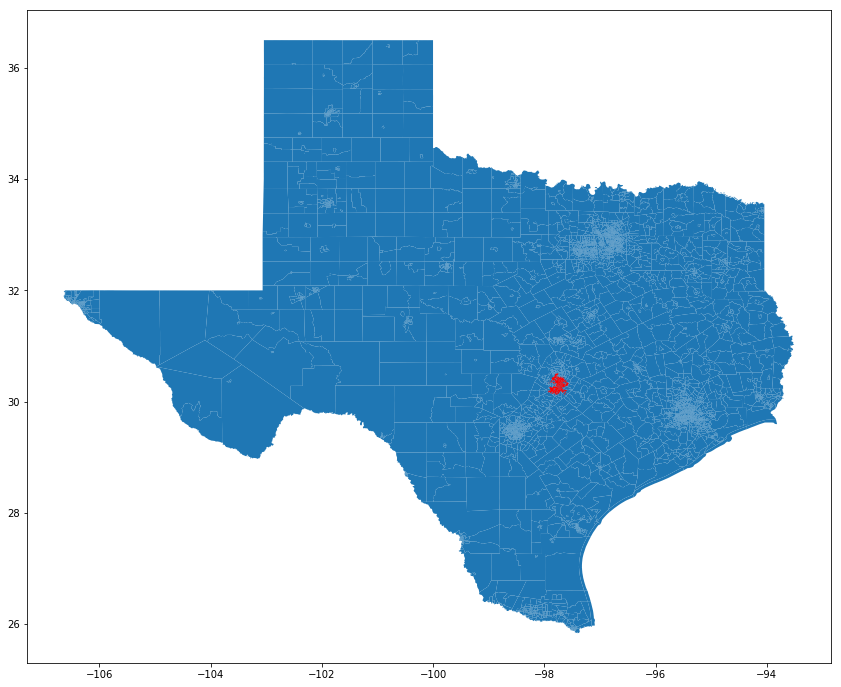

In [29]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')

census.plot(ax=ax)
districts.plot(ax=ax, color='red')

This is the location of Austin :D

# Phase 1: resampling

Now we need to "resample" (there might be a better word) the census tracts areas into the police precincts areas.

First, let's take a closer look at both maps.

## Visualize

In [30]:
minx = districts.bounds['minx'].min() - 0.02
maxx = districts.bounds['maxx'].max() + 0.02
miny = districts.bounds['miny'].min() - 0.02
maxy = districts.bounds['maxy'].max() + 0.02

print(minx, maxx, miny, maxy)

-97.95676948620425 -97.54051050177902 30.07837991731356 30.53661203236266


Text(0.5, 1.0, 'Census tracts')

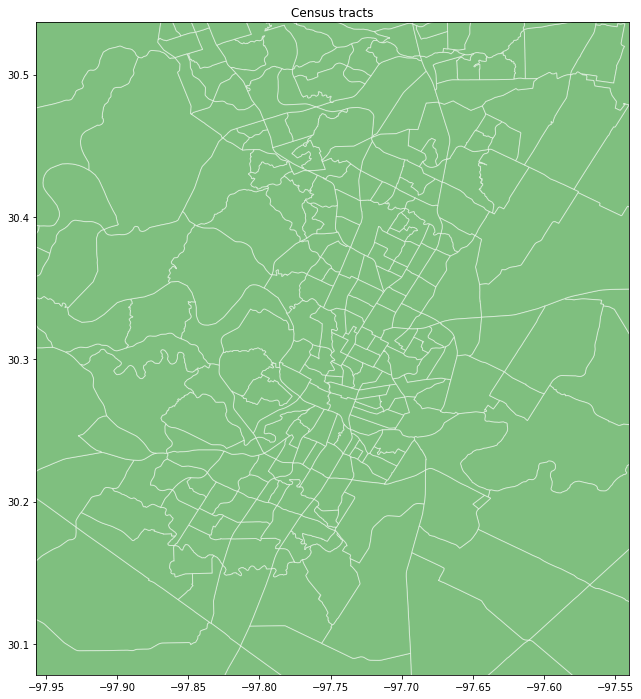

In [31]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

census.plot(ax=ax, color='green', edgecolor='white', alpha=0.5)

ax.set_title('Census tracts')

Text(0.5, 1.0, 'Police precincts')

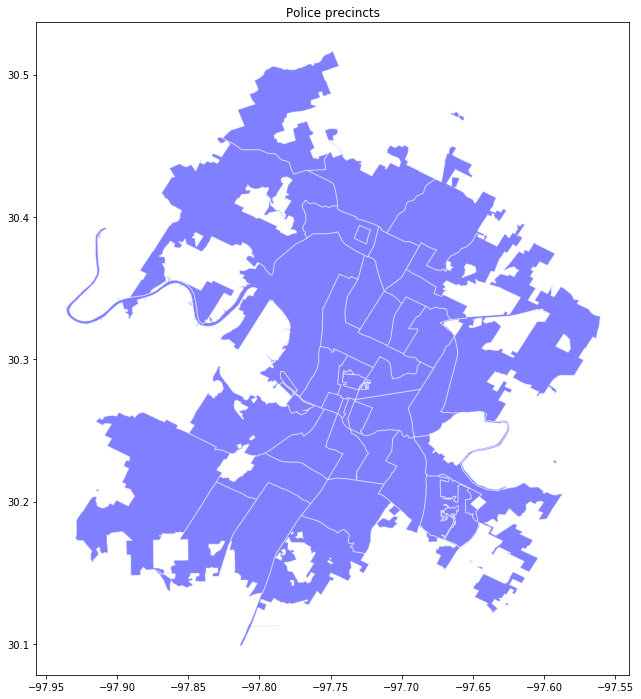

In [32]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

districts.plot(ax=ax, color='blue', edgecolor='white', alpha=0.5)

ax.set_title('Police precincts')

Text(0.5, 1.0, 'Census tracts + Police precincts')

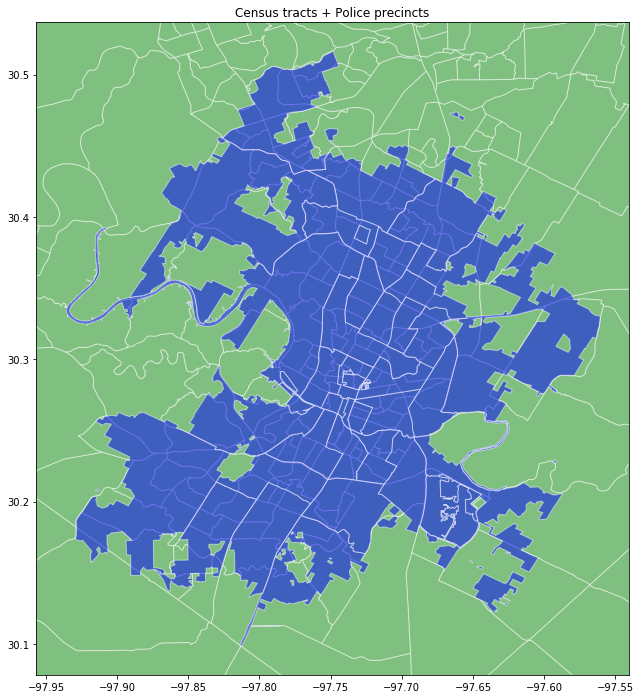

In [33]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

census.plot(ax=ax, color='green', edgecolor='white', alpha=0.5)
districts.plot(ax=ax, color='blue', edgecolor='white', alpha=0.5)

ax.set_title('Census tracts + Police precincts')

## Strategy

The plan here is, for each combination of Census tract + Police precincts, calculate their intersection.

To resample data from the Census shape into the Police shape, we assume the density in each Census shape is constant. We first calculate each density.

Now, each Police shape is composed of multiple small parts coming from district shapes. A better explanation can be found [here][1]. We just calculate the contribution of each of these small parts, based on their area and density, and then, we sum everything, to retrieve the final result for the Police shape.

*think land/water*

[1]: https://www.kaggle.com/center-for-policing-equity/data-science-for-good/discussion/67450

In [34]:
districts.shape[0] * census.shape[0]

279045

In [35]:
# optimization stage, only consider tracts that intersect with Austin districts
districts_total = cascaded_union(districts.geometry)
mask = census.geometry.apply(lambda x: districts_total.intersects(x))
census = census[mask]

Text(0.5, 1.0, 'Census tracts + Police precincts')

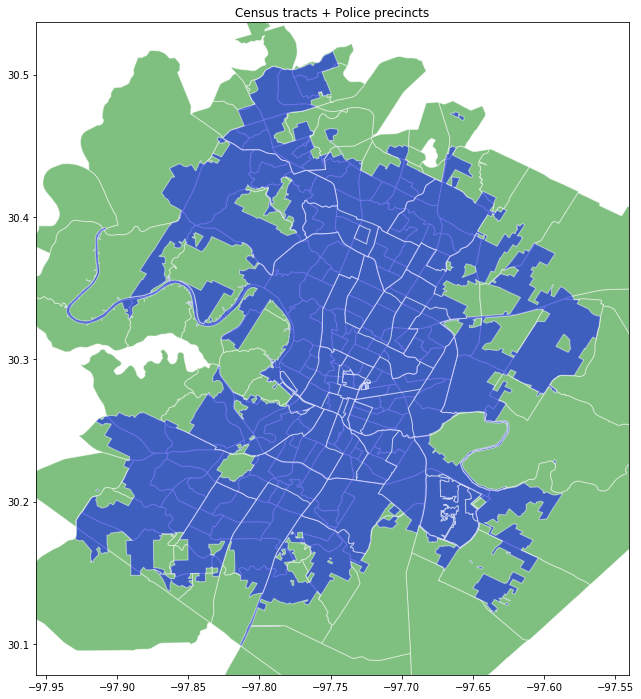

In [36]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

census.plot(ax=ax, color='green', edgecolor='white', alpha=0.5)
districts.plot(ax=ax, color='blue', edgecolor='white', alpha=0.5)

ax.set_title('Census tracts + Police precincts')

In [37]:
districts.shape[0] * census.shape[0]

# way faster :D

11607

In [38]:
intersections = []
for district_id, district in districts.iterrows():
    for tract_id, tract in census.iterrows():
        geom1 = district.geometry
        geom2 = tract.geometry
        intersection = geom1.intersection(geom2)
        if not intersection.is_empty:
            intersections.append((tract_id, district_id, intersection))
            
intersect_df = gpd.GeoDataFrame(
    intersections,
    columns=['Tract ID', 'District ID', 'Intersection'],
    crs=districts.crs,
    geometry='Intersection',
)
intersect_df.head()

Tract ID  District ID  \
0  48453002111            0   
1  48453001842            0   
2  48453001834            0   
3  48453002210            0   
4  48453002207            0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Intersection  
0  (POLYGON ((-97.66072825775585 30.2621950809912, -97.66080829908434 30.26215778380483, -97.6609558437514 30.26223924571506, -97.66103308333864 30.26228181003034, -97.66116799058726 30.26235632638178, -97.66117399557203 30.26235964100463, -97.66113899999999 30.262345, -97.660967 30.262282, -97.66076 30.262213, -97.66072825775585 30.2621950809912)), POLYGON ((-97.66185131738736 30.26274830759209, -97.66187601791542 30.26276447918294, -97.66188443963681 30.2627695075333, -97.66187599999999 30.26...  
1  POLYGON ((-97.62854353807847 30.36291050838774, -97.6285425019238 30.36291153614211, -97.62850179166058 30.36295165717745, -97.62774928874212 30.36369326552533, -97.62755762570804 30.36387239529075, -97.6275568706902 30.36387309275362, -97.62755563601756 30.3638742115701, -97.62755439487623 30.36387541963891, -97.62750500030818 30.36392150436426, -97.62750383313883 30.36392261944741, -97.62750262156422 30.36392376281692, -97.62749584153262 30.36393020704341, -97.62748340425962 30.36394172506...  
2  POLYGON ((-97.6692661940875 30.32699089714101, -97.6691849524705 30.32701938380882, -97.66903094850386 30.32706352299196, -97.66902985774502 30.32706384240525, -97.66869054094941 30.32716293866139, -97.66829652401707 30.32728176219615, -97.66804671054889 30.32735700962481, -97.66737785771171 30.3275589079913, -97.66733362216294 30.32757219910962, -97.66690113869909 30.32768336834221, -97.66689004044063 30.32768621453141, -97.66687892426255 30.32768906378495, -97.66670408163829 30.32773399418...  
3  (POLYGON ((-97.59607944703458 30.28191239236343, -97.59607901317911 30.2819121267378, -97.59607545581628 30.28190996386237, -97.59607389805437 30.28190901950801, -97.59606423290828 30.28190306293839, -97.59593802340518 30.28182584407645, -97.59591362957902 30.28181089182278, -97.59568465203741 30.28167071692384, -97.5949520338655 30.28120311792969, -97.59485868846393 30.28114338131369, -97.59468791838437 30.2810340362159, -97.59467656236602 30.28102645846603, -97.59412215518297 30.2806568429...  
4  (POLYGON ((-97.59168722812656 30.27862997250872, -97.59166910887865 30.27861510205102, -97.59161026598777 30.27856332277571, -97.59160700428508 30.27856045098523, -97.59159322682682 30.27854832934209, -97.59156008198127 30.27851915834722, -97.59155990970541 30.27851900675927, -97.591556 30.278476, -97.591571 30.278434, -97.59160700000001 30.278388, -97.59168099999999 30.27831, -97.591746 30.278229, -97.59176599999999 30.278182, -97.59176099999999 30.278121, -97.59172699999999 30.278036, -97....

In [39]:
intersect_df.shape

(519, 3)

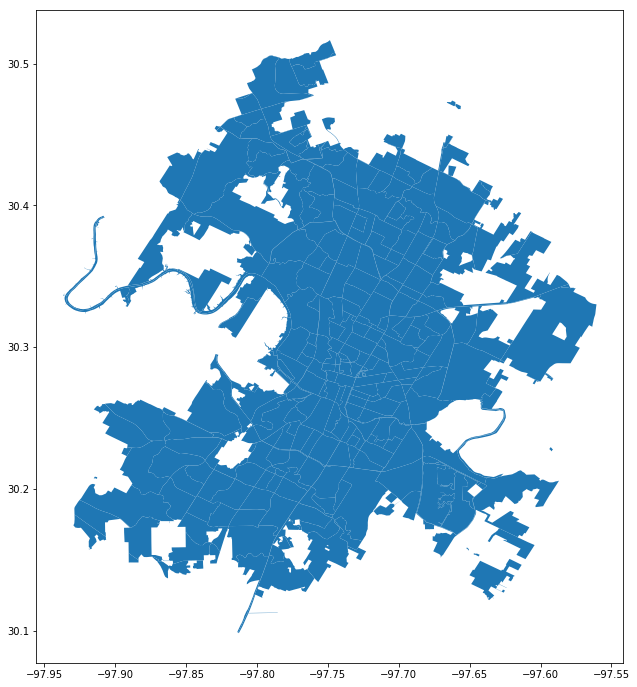

In [40]:
intersect_df.plot(figsize=(16, 12))
# all the little 519 intersections that are gonna compose this calculation

## Data selection

Now that we have the intersections, let's prepare the other side of the data... The values.

In [41]:
# racial features

demographics.head()

GEO.id                        GEO.display-label  \
GEO.id2                                                                      
48453000101  1400000US48453000101  Census Tract 1.01, Travis County, Texas   
48453000102  1400000US48453000102  Census Tract 1.02, Travis County, Texas   
48453000203  1400000US48453000203  Census Tract 2.03, Travis County, Texas   
48453000204  1400000US48453000204  Census Tract 2.04, Travis County, Texas   
48453000205  1400000US48453000205  Census Tract 2.05, Travis County, Texas   

             HC01_VC03  HC02_VC03  HC03_VC03 HC04_VC03  HC01_VC04  HC02_VC04  \
GEO.id2                                                                        
48453000101       4061        288       4061       (X)       1889        237   
48453000102       2556        195       2556       (X)       1176        157   
48453000203       1460        166       1460       (X)        608         93   
48453000204       3092        213       3092       (X)       1567        156   
48453000205       4154        474       4154       (X)       2473        468   

            HC03_VC04 HC04_VC04     ...      HC03_VC108  HC04_VC108  \
GEO.id2                             ...                               
48453000101      46.5       3.7     ...            3284         (X)   
48453000102      46.0       4.6     ...            1966         (X)   
48453000203      41.6       5.2     ...            1143         (X)   
48453000204      50.7       5.0     ...            2533         (X)   
48453000205      59.5       6.1     ...            3305         (X)   

            HC01_VC109 HC02_VC109  HC03_VC109  HC04_VC109 HC01_VC110  \
GEO.id2                                                                
48453000101       1469        203        44.7         3.7       1815   
48453000102        946        127        48.1         5.1       1020   
48453000203        467         88        40.9         5.9        676   
48453000204       1337        160        52.8         5.8       1196   
48453000205       2023        404        61.2         6.1       1282   

            HC02_VC110  HC03_VC110  HC04_VC110  
GEO.id2                                         
48453000101        141        55.3         3.7  
48453000102        122        51.9         5.1  
48453000203        120        59.1         5.9  
48453000204        203        47.2         5.8  
48453000205        163        38.8         6.1  

[5 rows x 338 columns]

In [42]:
# Estimate; SEX AND AGE - Total population
var1 = 'HC01_VC03'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race)
var2 = 'HC01_VC88'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - White alone
var3 = 'HC01_VC94'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Black or African American alone
var4 = 'HC01_VC95'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - American Indian and Alaska Native alone
var5 = 'HC01_VC96'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Asian alone
var6 = 'HC01_VC97'

# Note: there are more races and mix

demographics = demographics[[
    var1,
    var2,
    var3,
    var4,
    var5,
    var6,
]]

# demographics.columns = [
#     'Total1',
#     'Hispanic',  # or Latino
#     'White',
#     'Black',
#     'Indian',
#     'Asian',
# ]

demographics.head()

HC01_VC03  HC01_VC88  HC01_VC94  HC01_VC95  HC01_VC96  HC01_VC97
GEO.id2                                                                      
48453000101       4061        407       3460         24         13         47
48453000102       2556         83       2345         92          0          0
48453000203       1460        211       1083         56          0         84
48453000204       3092        415       2428         27          0        116
48453000205       4154        435       2999        130         14        433

In [43]:
# Total; Estimate; Population for whom poverty status is determined
var7 = 'HC01_EST_VC01'

# Below poverty level; Estimate; Population for whom poverty status is determined
var8 = 'HC02_EST_VC01'

poverty = poverty[[
    var7,
    var8,
]]

# poverty.columns = [
#     'Total2',
#     'Below Poverty',
# ]

poverty.head()

HC01_EST_VC01  HC02_EST_VC01
GEO.id2                                  
48453000101           4270            270
48453000102           2570             81
48453000203           1258            423
48453000204           3042            589
48453000205           4227            547

## Density

Here we need to calculate the density for the explanatory variables in each relevant census tract.

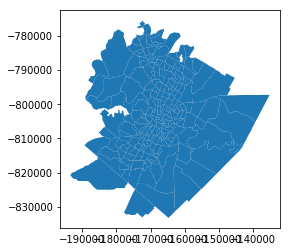

In [44]:
temp = census.to_crs(esri102003)
temp['area'] = temp.area
temp.plot()

In [45]:
joined = demographics.join(poverty)

print(f"Demographics {demographics.shape}")
print(f"Poverty {poverty.shape}")
print(f"Joined {joined.shape}")

Demographics (218, 6)
Poverty (218, 2)
Joined (218, 8)


In [46]:
d1 = temp.reset_index()
d2 = joined.reset_index()
d2['GEOID'] = d2['GEO.id2'].astype(str)

merged = d1.merge(d2, how='left', on='GEOID')

In [47]:
merged.isnull().sum()

# this may be a problem...

GEOID             0
STATEFP           0
COUNTYFP          0
TRACTCE           0
NAME              0
NAMELSAD          0
MTFCC             0
FUNCSTAT          0
ALAND             0
AWATER            0
INTPTLAT          0
INTPTLON          0
geometry          0
area              0
GEO.id2          18
HC01_VC03        18
HC01_VC88        18
HC01_VC94        18
HC01_VC95        18
HC01_VC96        18
HC01_VC97        18
HC01_EST_VC01    18
HC02_EST_VC01    18
dtype: int64

### Undiclosed information

There are some intersecting census tracts for which we have no demographics or poverty information. Wanna issue a complaint with CPE later, or, an idea, retrieve information directly from the ACS or AFF websites.

This little divergence explores the missing areas, later on we will continue our approach by ignoring the intersecting police districts... If it doesn't get so much out of hand (I think it won't).

**TODO:** Delete this section once problem is corrected.

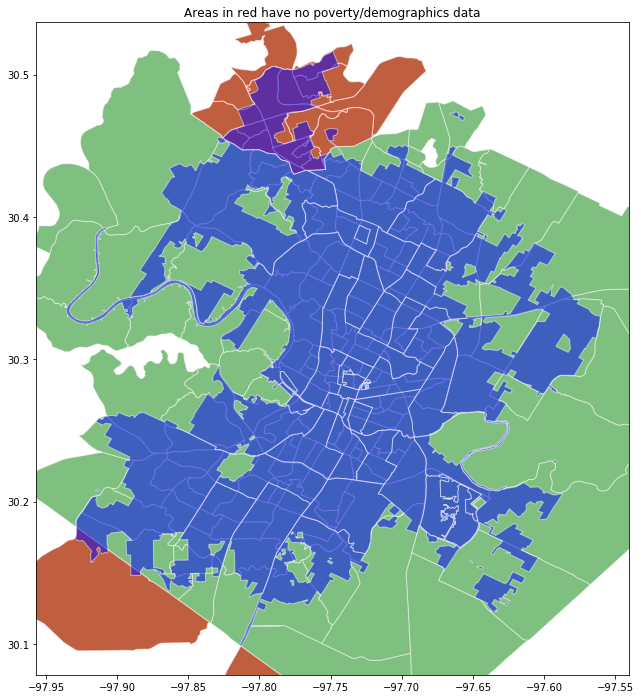

In [48]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

census.plot(ax=ax, color='green', edgecolor='white', alpha=0.5)
merged[merged.isnull().any(axis=1)] \
    .to_crs(epsg4326) \
    .plot(ax=ax, color='red', edgecolor='white', alpha=0.5)
districts.plot(ax=ax, color='blue', edgecolor='white', alpha=0.5)

ax.set_title('Areas in red have no poverty/demographics data');

### Back to the game

Let's just use information for census tracts for which we have information. That is, let's join the attributes and the geodata with an inner join

**Edit**: actually, let's perform a usual left join and then handle missing values later on the code

In [49]:
d1 = temp.reset_index()
d2 = joined.reset_index()
d2['GEOID'] = d2['GEO.id2'].astype(str)

merged = d1.merge(d2, how='left', on='GEOID')
merged.shape

(219, 23)

In [50]:
merged.head()

GEOID STATEFP COUNTYFP TRACTCE    NAME             NAMELSAD  MTFCC  \
0  48209010908      48      209  010908  109.08  Census Tract 109.08  G5020   
1  48453000402      48      453  000402    4.02    Census Tract 4.02  G5020   
2  48453000500      48      453  000500       5       Census Tract 5  G5020   
3  48453000601      48      453  000601    6.01    Census Tract 6.01  G5020   
4  48453000801      48      453  000801    8.01    Census Tract 8.01  G5020   

  FUNCSTAT     ALAND  AWATER      ...                area       GEO.id2  \
0        S  39031707  874308      ...        3.990604e+07           NaN   
1        S   1543583       0      ...        1.543582e+06  4.845300e+10   
2        S   1152030       0      ...        1.152032e+06  4.845300e+10   
3        S   1113392       0      ...        1.113389e+06  4.845300e+10   
4        S   1292330       0      ...        1.292330e+06  4.845300e+10   

  HC01_VC03  HC01_VC88  HC01_VC94  HC01_VC95  HC01_VC96  HC01_VC97  \
0       NaN        NaN        NaN        NaN        NaN        NaN   
1    3271.0      413.0     1738.0      657.0        0.0      256.0   
2    4894.0      712.0     3697.0       44.0        0.0      375.0   
3    9792.0     1934.0     5627.0     1079.0       13.0      917.0   
4    1638.0     1054.0      399.0      185.0        0.0        0.0   

   HC01_EST_VC01  HC02_EST_VC01  
0            NaN            NaN  
1         3346.0          722.0  
2         4565.0         1622.0  
3          798.0          527.0  
4         1679.0          295.0  

[5 rows x 23 columns]

Now let's calculate the densities for each tract.

In [51]:
densities = merged.loc[:, 'HC01_VC03':].div(merged.area, axis=0)
densities = merged[['GEOID']].join(densities)
densities = densities.set_index('GEOID')
densities.head()

# okay

HC01_VC03  HC01_VC88  HC01_VC94  HC01_VC95  HC01_VC96  HC01_VC97  \
GEOID                                                                           
48209010908        NaN        NaN        NaN        NaN        NaN        NaN   
48453000402   0.002119   0.000268   0.001126   0.000426   0.000000   0.000166   
48453000500   0.004248   0.000618   0.003209   0.000038   0.000000   0.000326   
48453000601   0.008795   0.001737   0.005054   0.000969   0.000012   0.000824   
48453000801   0.001267   0.000816   0.000309   0.000143   0.000000   0.000000   

             HC01_EST_VC01  HC02_EST_VC01  
GEOID                                      
48209010908            NaN            NaN  
48453000402       0.002168       0.000468  
48453000500       0.003963       0.001408  
48453000601       0.000717       0.000473  
48453000801       0.001299       0.000228

## Calculating amount for police districts

Now that we have densities and intersections, we can calculate the totals for each police district (damn, that's a long process).

In [52]:
intersect_df.head().drop('Intersection', axis=1)

Tract ID  District ID
0  48453002111            0
1  48453001842            0
2  48453001834            0
3  48453002210            0
4  48453002207            0

In [53]:
densities.head()

HC01_VC03  HC01_VC88  HC01_VC94  HC01_VC95  HC01_VC96  HC01_VC97  \
GEOID                                                                           
48209010908        NaN        NaN        NaN        NaN        NaN        NaN   
48453000402   0.002119   0.000268   0.001126   0.000426   0.000000   0.000166   
48453000500   0.004248   0.000618   0.003209   0.000038   0.000000   0.000326   
48453000601   0.008795   0.001737   0.005054   0.000969   0.000012   0.000824   
48453000801   0.001267   0.000816   0.000309   0.000143   0.000000   0.000000   

             HC01_EST_VC01  HC02_EST_VC01  
GEOID                                      
48209010908            NaN            NaN  
48453000402       0.002168       0.000468  
48453000500       0.003963       0.001408  
48453000601       0.000717       0.000473  
48453000801       0.001299       0.000228

In [54]:
# must use equal area projection for calculating areas (same as used to calculate densities)
intersect_df = intersect_df.to_crs(esri102003)

In [55]:
# may use some aggregation methods to facilitate here

district_totals = defaultdict(lambda: np.zeros(8))

for _, row in intersect_df.iterrows():
    tract_id = row['Tract ID']
    district_id = row['District ID']
    intersection = row['Intersection']
    area = intersection.area
    district_totals[district_id] += densities.loc[tract_id] * area

In [56]:
estimates = pd.DataFrame.from_dict(district_totals, orient='index')

In [57]:
estimates.shape

(53, 8)

In [58]:
estimates.head()

HC01_VC03     HC01_VC88    HC01_VC94    HC01_VC95  HC01_VC96  \
0  16220.891774   9664.631456  1766.025226  4451.877481   8.162891   
1   4696.676366   2496.801224  1680.836187   279.412521   2.397639   
2   1788.506487    218.069773  1261.452933    80.852423   0.000110   
3  18459.655902   8855.836092  5335.410631  3537.482249  39.026676   
4  17129.290679  10587.222023  3717.234171  2174.063820   0.004344   

    HC01_VC97  HC01_EST_VC01  HC02_EST_VC01  
0  109.516734   15970.890615    4469.280646  
1  172.789605    4758.223021     890.725016  
2  155.665729    1869.021844     181.837122  
3  373.289901   18249.675213    5189.608542  
4  347.426973   16326.385574    5322.936265

In [59]:
estimates.isnull().sum()

HC01_VC03        5
HC01_VC88        5
HC01_VC94        5
HC01_VC95        5
HC01_VC96        5
HC01_VC97        5
HC01_EST_VC01    5
HC02_EST_VC01    5
dtype: int64

Perfect! We estimated the amount of people in each police district (let's do this for Boston instead, daaamn)

## Visualizing results

It's always good to perform a visual check to see if our model is performing things correctly. Let's merge the raw counts with the geometry shapes and calculate some useful metrics. Later on, we want to account the margin of error (MOE).

TODO: plotting must be done on projections (choose a good one =D)

In [60]:
df = districts.merge(estimates, left_index=True, right_index=True)
df.head().drop('geometry', axis=1)

NAME  SORTORDER  BATID  JURIID       COLOR  CODE EXTERNALKE  \
0  CHARLIE 4        1.0  400.0    11.0  16744576.0  1282       1282   
1   GEORGE 1        1.0  194.0    15.0  16744576.0  1298       1298   
2   GEORGE 2        1.0  194.0    15.0  16776960.0  1297       1297   
3      IDA 1        1.0  215.0    60.0  16744576.0  1307       1307   
4      IDA 2        1.0  215.0    60.0  16711680.0  1304       1304   

  BATTALIONC   DISTRICT   SECTOR      ...          SHAPE_AREA      SHAPE_LEN  \
0       CHAR  CHARLIE 4  CHARLIE      ...        6.657440e+08  387953.791071   
1         G1   GEORGE 1   GEORGE      ...        2.790690e+07   23590.887752   
2         G1   GEORGE 2   GEORGE      ...        9.667245e+06   19773.819675   
3         I1      IDA 1      IDA      ...        1.054603e+08   48972.544807   
4         I1      IDA 2      IDA      ...        6.245594e+07   38742.443899   

      HC01_VC03     HC01_VC88    HC01_VC94    HC01_VC95  HC01_VC96  \
0  16220.891774   9664.631456  1766.025226  4451.877481   8.162891   
1   4696.676366   2496.801224  1680.836187   279.412521   2.397639   
2   1788.506487    218.069773  1261.452933    80.852423   0.000110   
3  18459.655902   8855.836092  5335.410631  3537.482249  39.026676   
4  17129.290679  10587.222023  3717.234171  2174.063820   0.004344   

    HC01_VC97  HC01_EST_VC01  HC02_EST_VC01  
0  109.516734   15970.890615    4469.280646  
1  172.789605    4758.223021     890.725016  
2  155.665729    1869.021844     181.837122  
3  373.289901   18249.675213    5189.608542  
4  347.426973   16326.385574    5322.936265  

[5 rows x 27 columns]

In [61]:
# REFERENCE


# Estimate; SEX AND AGE - Total population
var1 = 'HC01_VC03'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race)
var2 = 'HC01_VC88'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - White alone
var3 = 'HC01_VC94'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Black or African American alone
var4 = 'HC01_VC95'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - American Indian and Alaska Native alone
var5 = 'HC01_VC96'

# Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Asian alone
var6 = 'HC01_VC97'

# Total; Estimate; Population for whom poverty status is determined
var7 = 'HC01_EST_VC01'

# Below poverty level; Estimate; Population for whom poverty status is determined
var8 = 'HC02_EST_VC01'

### Comparison - Census tracts below poverty level

Before we plot the poverty level in the police districts, let's visualize them in the census tracts first. Data must align.

In [62]:
temp = census.copy()
temp.index = [int(x) for x in temp.index]
temp = temp.merge(poverty[[var7, var8]], how='inner', left_index=True, right_index=True)
temp.head().drop('geometry', axis=1)

STATEFP COUNTYFP TRACTCE  NAME           NAMELSAD  MTFCC FUNCSTAT  \
48453000402      48      453  000402  4.02  Census Tract 4.02  G5020        S   
48453000500      48      453  000500     5     Census Tract 5  G5020        S   
48453000601      48      453  000601  6.01  Census Tract 6.01  G5020        S   
48453000801      48      453  000801  8.01  Census Tract 8.01  G5020        S   
48453000803      48      453  000803  8.03  Census Tract 8.03  G5020        S   

               ALAND  AWATER     INTPTLAT      INTPTLON  HC01_EST_VC01  \
48453000402  1543583       0  +30.2841390  -097.7155242           3346   
48453000500  1152030       0  +30.2960656  -097.7341753           4565   
48453000601  1113392       0  +30.2874117  -097.7380441            798   
48453000801  1292330       0  +30.2669542  -097.7014857           1679   
48453000803  1444991       0  +30.2768115  -097.7204722           2215   

             HC02_EST_VC01  
48453000402            722  
48453000500           1622  
48453000601            527  
48453000801            295  
48453000803            236

/home/andre/miniconda3/envs/cpe/lib/python3.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


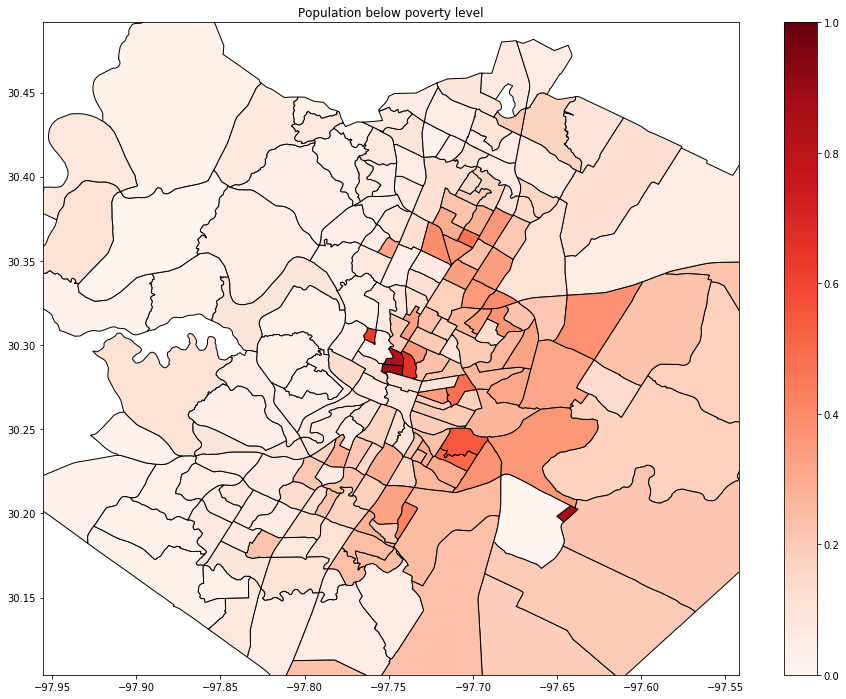

In [63]:
xlim = (-97.95558243542551, -97.54169755255776)
ylim = (30.10407831924847, 30.491603303384252)

temp['shade'] = temp['HC02_EST_VC01'] / temp['HC01_EST_VC01']
ax = temp.plot(column='shade', edgecolor='k', cmap='Reds', vmin=0.0, vmax=1.0, legend=True, figsize=(16, 12))
plt.title('Population below poverty level')
ax.set_xlim(xlim)
ax.set_ylim(ylim);

Compare with plot below... Looks reasonable. Later on we can perform better tests.

### Below poverty level percent

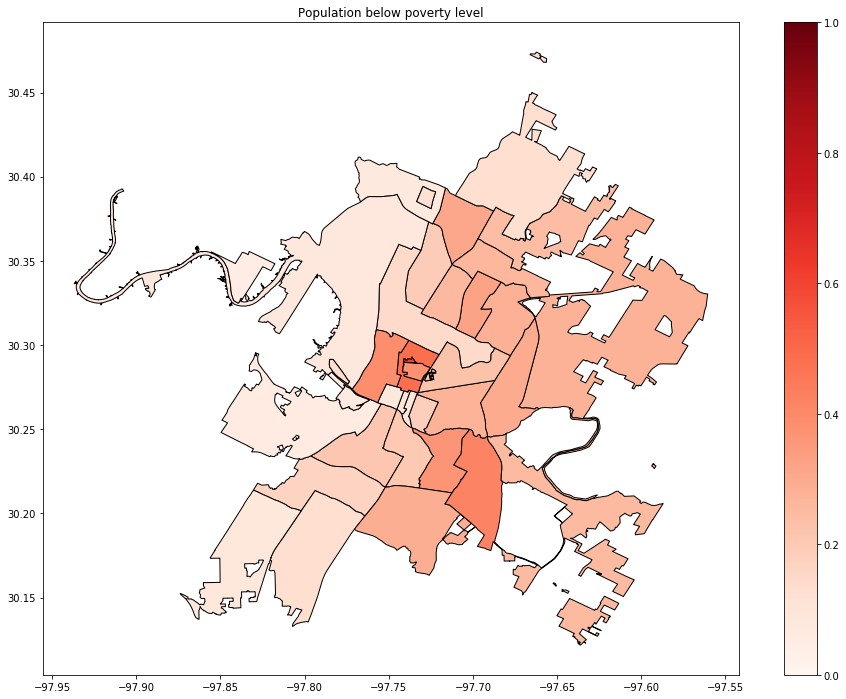

In [64]:
to_plot = df.copy()
to_plot['shade'] = df['HC02_EST_VC01'] / df['HC01_EST_VC01']
to_plot = to_plot[to_plot.shade.notnull()]
ax = to_plot.plot(column='shade', edgecolor='k', cmap='Reds', vmin=0.0, vmax=1.0, legend=True, figsize=(16, 12))
plt.title('Population below poverty level');

### Racial composition

In [65]:
total = df['HC01_VC03']
hispanic = df['HC01_VC88']
white = df['HC01_VC94']
black = df['HC01_VC95']
native = df['HC01_VC96']
asian = df['HC01_VC97']

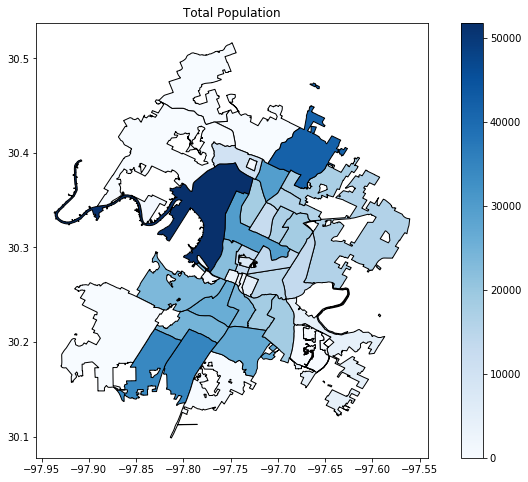

In [66]:
to_plot = df.copy()
to_plot['shade'] = total
to_plot.plot(column='shade', edgecolor='k', legend=True, cmap='Blues', figsize=(12, 8))
plt.title('Total Population');

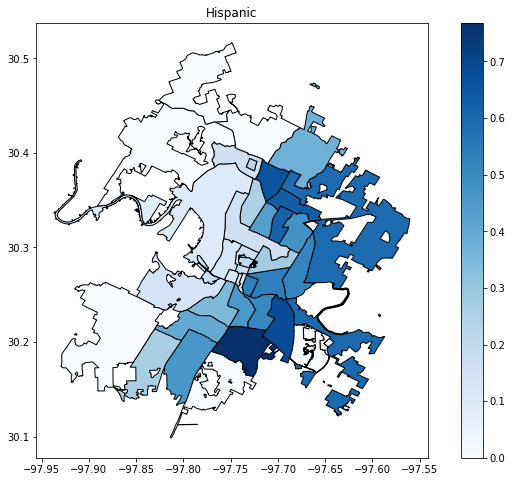

In [67]:
to_plot = df.copy()
to_plot['shade'] = hispanic / total
to_plot.plot(column='shade', edgecolor='k', cmap='Blues', vmin=0, legend=True, figsize=(12, 8))
plt.title('Hispanic');

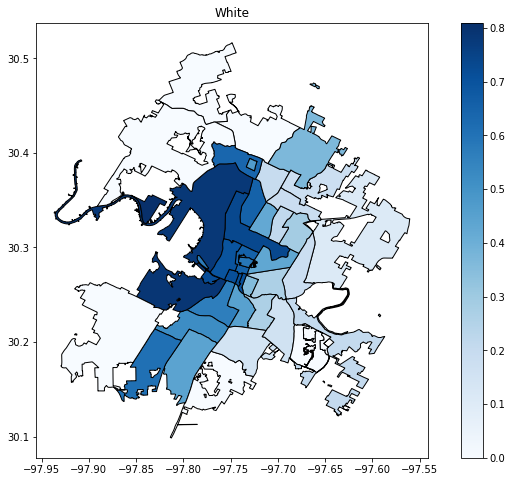

In [68]:
to_plot = df.copy()
to_plot['shade'] = white / total
to_plot.plot(column='shade', edgecolor='k', cmap='Blues', vmin=0, legend=True, figsize=(12, 8))
plt.title('White');

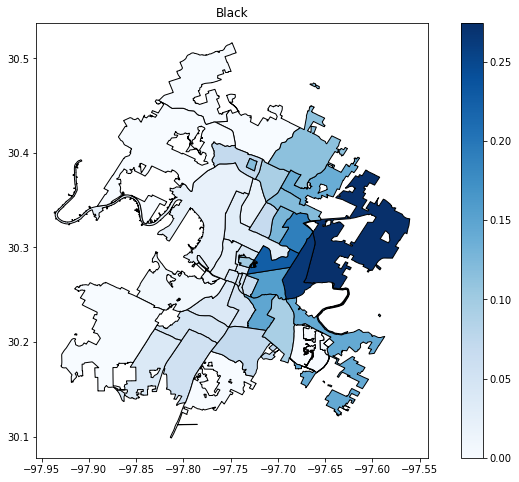

In [69]:
to_plot = df.copy()
to_plot['shade'] = black / total
to_plot.plot(column='shade', edgecolor='k', cmap='Blues', vmin=0, legend=True, figsize=(12, 8))
plt.title('Black');

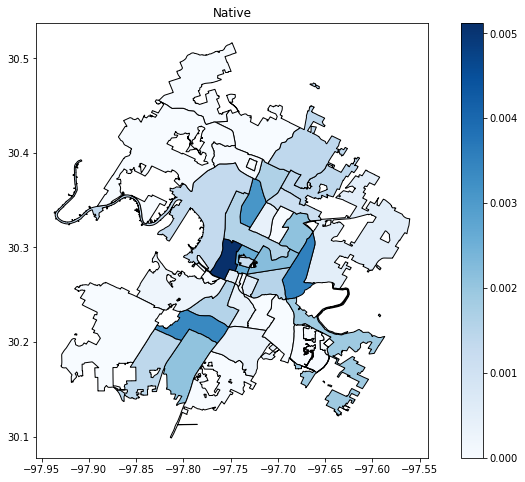

In [70]:
to_plot = df.copy()
to_plot['shade'] = native / total
to_plot.plot(column='shade', edgecolor='k', cmap='Blues', vmin=0, legend=True, figsize=(12, 8))
plt.title('Native');

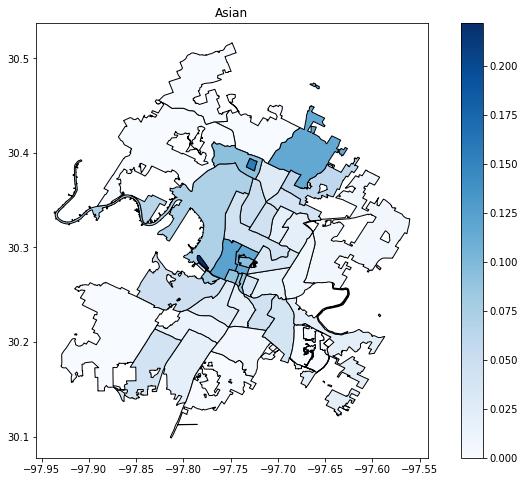

In [71]:
to_plot = df.copy()
to_plot['shade'] = asian / total
to_plot.plot(column='shade', edgecolor='k', cmap='Blues', vmin=0, legend=True, figsize=(12, 8))
plt.title('Asian');

# Phase 1.5: Aggregating pontual data

We have resampled data that were in the census tracts into the police districts (oof). Now we need to collect the granular data into the police districts themselves, generating aggregate statistics.

The first problem to think of here is:

- How are we supposed to aggregate these points?

The first solution and most obvious is, each point that happens inside a police district will be related to that police district. Geopandas has a spatial aggregation tools that shall do this nicely. Manual effort wouldn't be that hard either.

The second solution that comes to mind is, to use some metadata about the incident. For example, it may contain information about what district it is related to. This may break the standard in the previous resampling (Phase 1). But, it provides the most accurate data and process is even simpler. If there's no data for this approach, however, we will need to stick with the first...

Let's check!

Also, does each police district only have competence in its distrct area?

## Crimes

Crimes should not be related to any police districts in special, except for the place where it occurs.

So, we will use the solution #1, that is, join those points spatially.

In [72]:
crimes.shape

(116879, 27)

In [73]:
crimes.head()

Incident Number Highest Offense Description  Highest Offense Code  \
0      20155006575         FORGERY AND PASSING                  1000   
1      20151891608                  AUTO THEFT                   700   
2      20155050011                       THEFT                   600   
3      20158004086                       THEFT                   600   
4      20155054719            DEBIT CARD ABUSE                  1108   

  Family Violence  Occurred Date Time Occurred Date  Occurred Time  \
0               N 2015-02-11 15:29:00    02/11/2015           1529   
1               N 2015-07-07 17:50:00    07/07/2015           1750   
2               N 2015-11-02 12:00:00    11/02/2015           1200   
3               N 2015-11-12 00:30:00    11/12/2015             30   
4               N 2015-12-13 12:00:00    12/13/2015           1200   

         Report Date Time Report Date  Report Time  \
0  02/15/2015 03:29:00 PM  02/15/2015         1529   
1  07/08/2015 10:01:00 PM  07/08/2015         2201   
2  11/12/2015 04:27:00 PM  11/12/2015         1627   
3  11/12/2015 03:18:00 AM  11/12/2015          318   
4  12/15/2015 02:28:00 PM  12/15/2015         1428   

              ...              Census Tract Clearance Status  Clearance Date  \
0             ...                      9.02                N      2015-02-17   
1             ...                     17.53                N      2015-07-22   
2             ...                     21.05                N      2015-11-18   
3             ...                     11.00                N      2015-11-18   
4             ...                     19.01                N      2015-12-15   

   UCR Category Category Description X-coordinate  Y-coordinate   Latitude  \
0           NaN                  NaN    3121952.0     3121952.0  30.261677   
1           240           Auto Theft    3114335.0     3114335.0  30.382723   
2           23H                Theft    3126309.0     3126309.0  30.318529   
3           23H                Theft    3113125.0     3113125.0  30.265331   
4           NaN                  NaN    3096831.0     3096831.0  30.238552   

   Longitude                     Location  
0 -97.718775  (30.26167703, -97.71877525)  
1 -97.739657  (30.38272339, -97.73965657)  
2 -97.703422    (30.3185291, -97.7034222)  
3 -97.746644   (30.26533133, -97.7466441)  
4 -97.798973  (30.23855227, -97.79897319)  

[5 rows x 27 columns]

In [74]:
crimes['Occurred Date Time'].dt.year.value_counts()

2015    115331
2014      1170
2013       137
2012        71
2011        44
2010        35
2009        23
2005        15
2006        14
2008        13
2007        11
2003         8
2004         7
Name: Occurred Date Time, dtype: int64

Let's use only crimes that happened in 2015.

In [75]:
crimes = crimes[crimes['Occurred Date Time'].dt.year == 2015]

In [76]:
crimes.isnull().mean()

Incident Number                0.000000
Highest Offense Description    0.000000
Highest Offense Code           0.000000
Family Violence                0.000000
Occurred Date Time             0.000000
Occurred Date                  0.000000
Occurred Time                  0.000000
Report Date Time               0.000000
Report Date                    0.000000
Report Time                    0.000000
Location Type                  0.004639
Address                        0.000000
Zip Code                       0.009208
Council District               0.010769
APD Sector                     0.006815
APD District                   0.007162
PRA                            0.008116
Census Tract                   0.009208
Clearance Status               0.085875
Clearance Date                 0.085875
UCR Category                   0.670592
Category Description           0.670592
X-coordinate                   0.007778
Y-coordinate                   0.007778
Latitude                       0.020064


### XY-Coordinates

I believe the X-coordinate and Y-coordinate point to the longitude and latitude. We can check this using a correlation check.

**plots below are misleading... the points are clustered at the ends, not the middle of line**

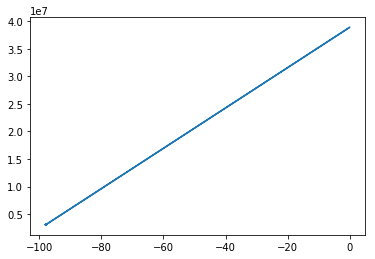

In [77]:
xs = crimes['Longitude']
ys = crimes['Y-coordinate']

plt.plot(xs, ys)

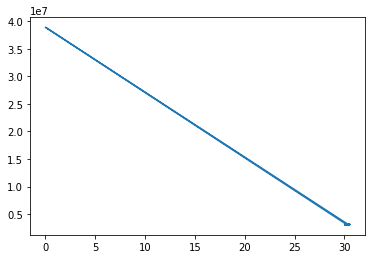

In [78]:
xs = crimes['Latitude']
ys = crimes['X-coordinate']

plt.plot(xs, ys)

# this is reversed

They do point, yes, but *there are some distortions at the extremes*.

(2800000.0, 3500000.0)

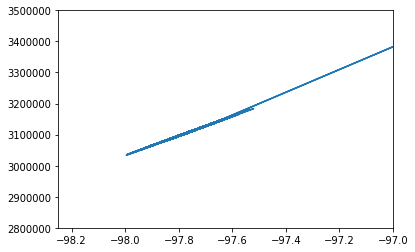

In [79]:
xs = crimes['Longitude']
ys = crimes['Y-coordinate']

plt.plot(xs, ys)

plt.xlim(-98.25, -97)
plt.ylim(0.28e7, 0.35e7)

A projection artifact, maybe (?) ...

To avoid problems, let's just use entries where the latlon are well known. Later we can fill in missing values.

### Latitude and Longitude

We need to convert this dataframe into a geodataframe. This won't be hard.

In [80]:
# first, create Shapely Points from latitude and longitude

points = [Point(ser.Longitude, ser.Latitude) for _, ser in crimes.iterrows()]
geocrimes = gpd.GeoDataFrame(
    crimes.drop(['Latitude', 'Longitude', 'Location'], axis=1),
    geometry=points,
    crs=epsg4326,
)

In [81]:
geocrimes.head()

Incident Number Highest Offense Description  Highest Offense Code  \
0      20155006575         FORGERY AND PASSING                  1000   
1      20151891608                  AUTO THEFT                   700   
2      20155050011                       THEFT                   600   
3      20158004086                       THEFT                   600   
4      20155054719            DEBIT CARD ABUSE                  1108   

  Family Violence  Occurred Date Time Occurred Date  Occurred Time  \
0               N 2015-02-11 15:29:00    02/11/2015           1529   
1               N 2015-07-07 17:50:00    07/07/2015           1750   
2               N 2015-11-02 12:00:00    11/02/2015           1200   
3               N 2015-11-12 00:30:00    11/12/2015             30   
4               N 2015-12-13 12:00:00    12/13/2015           1200   

         Report Date Time Report Date  Report Time  \
0  02/15/2015 03:29:00 PM  02/15/2015         1529   
1  07/08/2015 10:01:00 PM  07/08/2015         2201   
2  11/12/2015 04:27:00 PM  11/12/2015         1627   
3  11/12/2015 03:18:00 AM  11/12/2015          318   
4  12/15/2015 02:28:00 PM  12/15/2015         1428   

                    ...                   APD District    PRA  Census Tract  \
0                   ...                              1  419.0          9.02   
1                   ...                              1  216.0         17.53   
2                   ...                              2  292.0         21.05   
3                   ...                              4  405.0         11.00   
4                   ...                              3  466.0         19.01   

   Clearance Status Clearance Date UCR Category  Category Description  \
0                 N     2015-02-17          NaN                   NaN   
1                 N     2015-07-22          240            Auto Theft   
2                 N     2015-11-18          23H                 Theft   
3                 N     2015-11-18          23H                 Theft   
4                 N     2015-12-15          NaN                   NaN   

   X-coordinate Y-coordinate                                geometry  
0     3121952.0    3121952.0  POINT (-97.71877524999999 30.26167703)  
1     3114335.0    3114335.0  POINT (-97.73965656999999 30.38272339)  
2     3126309.0    3126309.0   POINT (-97.70342220000001 30.3185291)  
3     3113125.0    3113125.0         POINT (-97.7466441 30.26533133)  
4     3096831.0    3096831.0        POINT (-97.79897319 30.23855227)  

[5 rows x 25 columns]

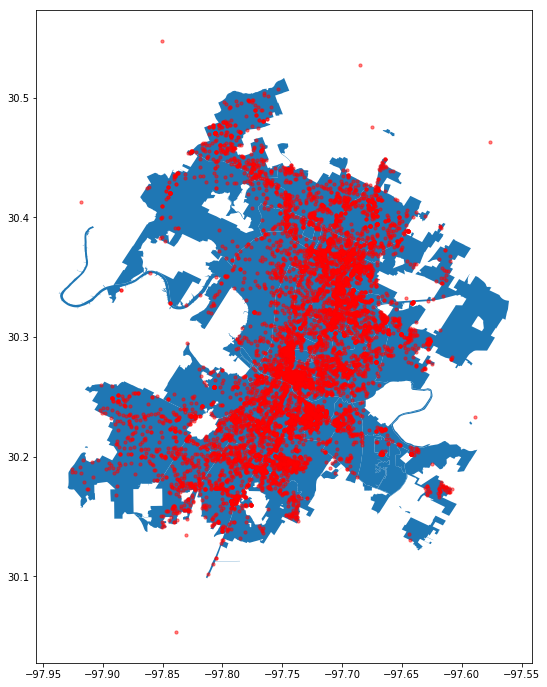

In [82]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')

districts.to_crs(epsg4326).plot(ax=ax)
geocrimes.sample(10000, random_state=1).plot(ax=ax, color='red', alpha=0.5, markersize=10)

There are *some* points that happen outside the districts boundaries (e.g. in another city (?)). We can ignore them safely. Overall, the result brings me satisfaction :D

### Joining

In [83]:
districts.crs

{'init': 'epsg:4326'}

In [84]:
geocrimes.crs

{'init': 'epsg:4326'}

In [85]:
# to join
tj1 = districts[['geometry']].copy()
tj2 = geocrimes.copy()

tj1.index.name = 'district_id'
tj2.index.name = 'crime_id'

tj1 = tj1.reset_index()
tj2 = tj2.reset_index()

joined = gpd.sjoin(tj1, tj2, how='inner', op='intersects')
joined = joined.reset_index(drop=True)
joined = joined.drop('index_right', axis=1)

joined.head().drop('geometry', axis=1)

district_id  crime_id  Incident Number     Highest Offense Description  \
0            0     19581      20153380020                  POSS MARIJUANA   
1            0     22842      20152181661      WARRANT ARREST NON TRAFFIC   
2            0     67005      20152221857       AGG ROBBERY/DEADLY WEAPON   
3            0     66224       2015441039  ASSAULT W/INJURY-FAM/DATE VIOL   
4            0     76983      20153170849  ASSAULT W/INJURY-FAM/DATE VIOL   

   Highest Offense Code Family Violence  Occurred Date Time Occurred Date  \
0                  1803               N 2015-12-04 01:37:00    12/04/2015   
1                  3442               N 2015-08-06 21:12:00    08/06/2015   
2                   300               N 2015-08-10 22:20:00    08/10/2015   
3                   900               Y 2015-02-11 21:00:00    02/11/2015   
4                   900               Y 2015-11-11 17:30:00    11/11/2015   

   Occurred Time        Report Date Time      ...      APD Sector  \
0            137  12/04/2015 01:37:00 AM      ...              CH   
1           2112  08/06/2015 09:12:00 PM      ...              CH   
2           2220  08/10/2015 11:14:00 PM      ...              CH   
3           2100  02/13/2015 03:52:00 PM      ...              CH   
4           1730  11/13/2015 01:00:00 PM      ...              CH   

   APD District    PRA Census Tract  Clearance Status  Clearance Date  \
0             4  302.0        22.02                 C      2015-12-11   
1             4  302.0        22.02                 C      2015-08-19   
2             4  302.0        22.02                 N      2015-09-16   
3             4  302.0        22.02                 O      2015-02-27   
4             4  303.0        22.08                 O      2015-12-08   

  UCR Category Category Description  X-coordinate  Y-coordinate  
0          NaN                  NaN     3149348.0     3149348.0  
1          NaN                  NaN     3149348.0     3149348.0  
2          120              Robbery     3149385.0     3149385.0  
3          NaN                  NaN     3149385.0     3149385.0  
4          NaN                  NaN     3145528.0     3145528.0  

[5 rows x 26 columns]

In [86]:
joined.groupby('district_id').apply(lambda df: df['Highest Offense Description'].value_counts())[6]

# the types of crimes commited for each district are veery different
# we need to create a map of this


# splitting crime types before feeding the model may be a good idea too

BURGLARY OF VEHICLE               208
THEFT                             185
FAMILY DISTURBANCE                165
CRIMINAL MISCHIEF                 146
DISTURBANCE - OTHER                82
BURGLARY OF RESIDENCE              81
ASSAULT W/INJURY-FAM/DATE VIOL     65
DWI                                63
AUTO THEFT                         56
BURGLARY NON RESIDENCE             51
THEFT OF BICYCLE                   44
IDENTITY THEFT                     41
CUSTODY ARREST TRAFFIC WARR        39
ASSAULT WITH INJURY                38
HARASSMENT                         36
FRAUD - OTHER                      34
THEFT BY SHOPLIFTING               30
WARRANT ARREST NON TRAFFIC         28
THEFT OF SERVICE                   28
PUBLIC INTOXICATION                27
POSS MARIJUANA                     24
ASSAULT BY CONTACT                 22
RUNAWAY CHILD                      22
POSS CONTROLLED SUB/NARCOTIC       21
ASSAULT BY THREAT                  20
GRAFFITI                           19
DEBIT CARD A

### Visualize

In [87]:
total_crimes = joined.groupby('district_id').size()
total_crimes.name = 'total_crimes'
total_crimes.head()

district_id
0    2446
1    1837
2    3666
3    3303
4    4160
Name: total_crimes, dtype: int64

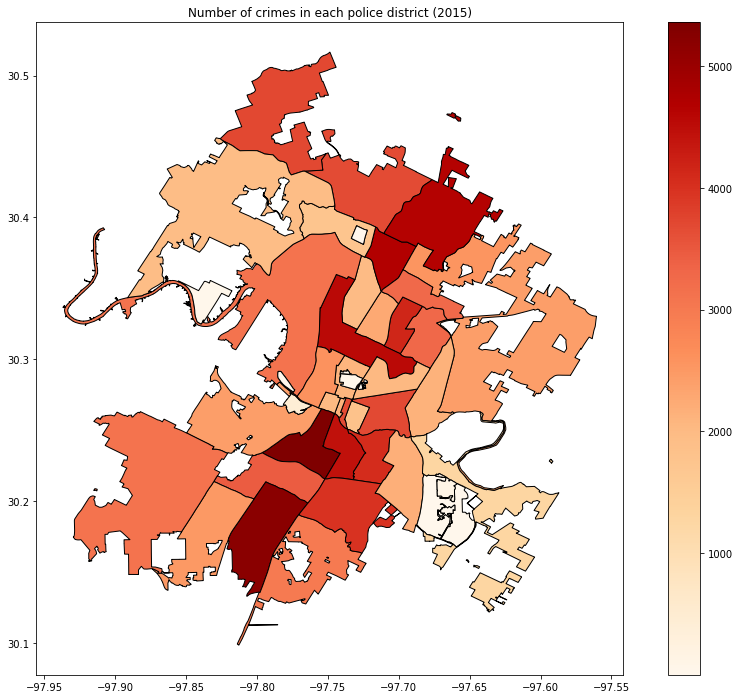

In [88]:
to_plot = districts.copy()
to_plot = to_plot.join(total_crimes, how='inner')
ax = to_plot.plot(figsize=(16, 12), column='total_crimes', cmap='OrRd', edgecolor='k', legend=True)
ax.set_title('Number of crimes in each police district (2015)');

## UOF Incidents

These points are a bit less clear on the way we should procede. Each point happens inside a police district, but maybe they are related to another district. Let's investigate it a bit.

Ref:

https://nextdoor.com/agency-post/tx/austin/austin-police/apd-sector-and-district-boundaries-56856339/

In [90]:
incidents.isnull().mean()

RIN                                             0.000000
PRIMARY_KEY                                     0.000000
INCIDENT_DATE                                   0.000000
LOCATION_DISTRICT                               0.001793
INCIDENT_REASON                                 0.000316
REASON_FOR_FORCE                                0.000316
SUBJECT_ID                                      0.004745
SUBJECT_GENDER                                  0.034166
SUBJECT_RACE                                    0.036065
SUBJECT_ROLE                                    0.695455
SUBJECT_DESCRIPTION                             0.195930
REASON_FOR_FORCE.1                              0.000422
TYPE_OF_FORCE_USED1                             0.003691
TYPE_OF_FORCE_USED2                             0.952230
TYPE_OF_FORCE_USED3                             0.993357
TYPE_OF_FORCE_USED4                             0.999473
NUMBER_EC_CYCLES                                0.794053
SUBJECT_INJURY_TYPE            

### X-coordinate / Y-coordinate

Since we have about 77% of missing values in the latitude/longitude values, we will WANT to use the Y_COORDINATE values. These are probably just the coordinates for the point in a given projection and we hope this projection is the same one we're using here. To test this hypothesis, we check the correlation between variables.

In [198]:
def to_float(x):
    if x == '-':
        return np.nan
    return float(x)

temp = incidents[['X-Coordinate', 'Y-Coordinate', 'Latitude', 'Longitude']]
temp.corr(method='spearman')

X-Coordinate  Y-Coordinate  Latitude  Longitude
X-Coordinate      1.000000      0.489071  0.542899   0.998635
Y-Coordinate      0.489071      1.000000  0.999538   0.578415
Latitude          0.542899      0.999538  1.000000   0.573206
Longitude         0.998635      0.578415  0.573206   1.000000

The X-Coordinate is liked to the Longitude and the Y-Coordinate is linked to the latitude, as was expected.

Let's check if the projection we've been using for Austin matches...

In [199]:
temp = temp[temp.Latitude.notnull() & temp.Longitude.notnull()]
xy_coords = [Point(x, y) for x, y in zip(temp['X-Coordinate'], temp['Y-Coordinate'])]
ll_coords = [Point(x, y) for x, y in zip(temp['Longitude'], temp['Latitude'])]

xy_coords = gpd.GeoSeries(xy_coords, crs=esri102739)
ll_coords = gpd.GeoSeries(ll_coords, crs=epsg4326)

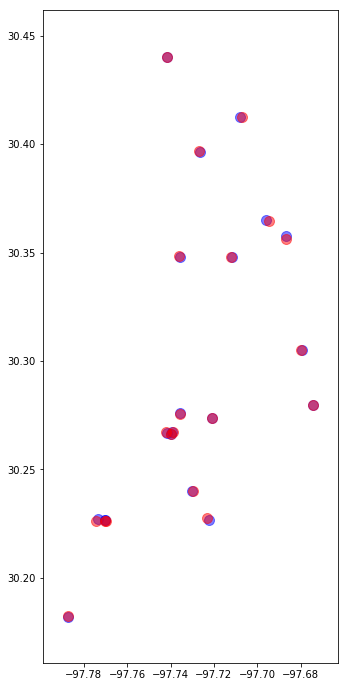

In [200]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')

ll_coords.sample(20, random_state=1).plot(ax=ax, color='blue', alpha=0.5, markersize=100)
xy_coords.sample(20, random_state=1).to_crs(epsg4326).plot(ax=ax, color='red', alpha=0.5, markersize=100);

Though some points are a bit off, most of them are exactly on top of each other. This indicates different methods of assigning each value, not just a simple conversion. We will stick with this and it is probably the best we can ever get.

### Creating a GeoDataFrame

In [205]:
points = [Point(x, y) for x, y in zip(incidents['X-Coordinate'], incidents['Y-Coordinate'])]
geoincidents = gpd.GeoDataFrame(
    incidents.drop(['X-Coordinate', 'Y-Coordinate', 'Latitude', 'Longitude'], axis=1),
    geometry=points,
    crs=esri102739,
)
geoincidents = geoincidents.to_crs(epsg4326)

geoincidents.head().drop('geometry', axis=1)

RIN  Primary Key Date Occurred Area Command Nature of Contact  \
0  156701   2015541517     2/24/2015           FR    VIEWED OFFENSE   
1  161046  20151510003     5/31/2015           GE    VIEWED OFFENSE   
2  161381  20151510003     5/31/2015           GE    VIEWED OFFENSE   
3  142588   2014111929     1/11/2014           HE      TRAFFIC STOP   
4  162084  20151720001     6/21/2015           GE   DISPATCHED CALL   

                              Reason Desc       Master Subject ID Subject Sex  \
0  NECESSARY TO EFFECT ARREST / DETENTION   167510327: 2015541517           M   
1  NECESSARY TO EFFECT ARREST / DETENTION  459191174: 20151510003           M   
2         IN CUSTODY, MAINTAINING CONTROL  459191174: 20151510003           M   
3   NECESSARY TO DEFEND REPORTING OFFICER   198377769: 2014111929           M   
4         TO RESTRAIN FOR SUBJECTS SAFETY  459030448: 20151720001           M   

       Race Subject Role  ...  Weapon Used 4 Number Shots  \
0  Hispanic          NaN  ...            NaN          NaN   
1  Hispanic          NaN  ...            NaN          NaN   
2  Hispanic          NaN  ...            NaN          1.0   
3     Black      SUSPECT  ...            NaN          NaN   
4     Black          NaN  ...            NaN          NaN   

               Subject Effects            Effect on Officer  \
0  NO COMPLAINT OF INJURY/PAIN  NO COMPLAINT OF INJURY/PAIN   
1  NO COMPLAINT OF INJURY/PAIN  NO COMPLAINT OF INJURY/PAIN   
2  NO COMPLAINT OF INJURY/PAIN  NO COMPLAINT OF INJURY/PAIN   
3     COMPLAINT OF INJURY/PAIN  NO COMPLAINT OF INJURY/PAIN   
4  NO COMPLAINT OF INJURY/PAIN  NO COMPLAINT OF INJURY/PAIN   

    Officer Organization Desc Officer Yrs of Service  City Council District  \
0  CRIMINAL INTERDICTION / K9                      3                    5.0   
1     GEORGE 300 REG I PATROL                      5                    9.0   
2     GEORGE 300 REG I PATROL                      7                    9.0   
3    HENRY 700 REG III PATROL                      4                    NaN   
4     GEORGE 400 REG I PATROL                      3                    3.0   

                 Geolocation    City State  
0      9900 BLOCK S IH 35 SB  Austin    TX  
1               409 E 6TH ST  Austin    TX  
2               409 E 6TH ST  Austin    TX  
3    BURTON DR / E OLTORF ST  Austin    TX  
4  SAN MARCOS ST / SPENCE ST  Austin    TX  

[5 rows x 25 columns]

### Prepare

Let's use onlt incidents from 2015.

In [214]:
geoincidents['Date Occurred'] = pd.to_datetime(geoincidents['Date Occurred'])
geoincidents = geoincidents[geoincidents['Date Occurred'].dt.year == 2015]

In [215]:
geoincidents.shape

(3302, 26)

### Visualizing

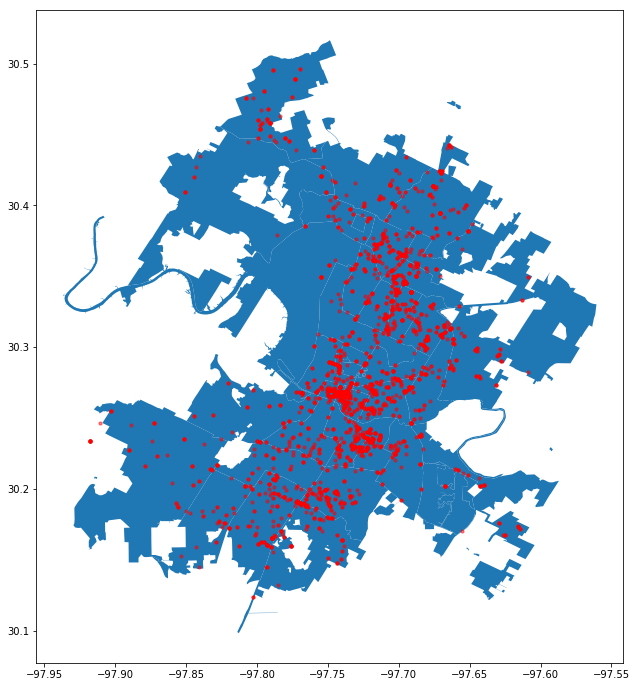

In [217]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.set_aspect('equal')

districts.to_crs(epsg4326).plot(ax=ax)
geoincidents \
    .plot(ax=ax, alpha=0.5, markersize=10, color='red')

This is interesting... The UOF incidents seem to occur at specific strips.

### Joining

This step will have to be rethought further... Different kinds of incidents occur in different places. Right now, though, we can just account the total of incidents, regardless of what they meant.

Also, *later on*, we may want to consider the races here, since we have the race information. A nice tool would be visualizing the amount of incidents for each race in the city!

In [220]:
districts.reset_index().head()

index_left       NAME  SORTORDER  BATID  JURIID       COLOR  CODE  \
0           0  CHARLIE 4        1.0  400.0    11.0  16744576.0  1282   
1           1   GEORGE 1        1.0  194.0    15.0  16744576.0  1298   
2           2   GEORGE 2        1.0  194.0    15.0  16776960.0  1297   
3           3      IDA 1        1.0  215.0    60.0  16744576.0  1307   
4           4      IDA 2        1.0  215.0    60.0  16711680.0  1304   

  EXTERNALKE BATTALIONC   DISTRICT  \
0       1282       CHAR  CHARLIE 4   
1       1298         G1   GEORGE 1   
2       1297         G1   GEORGE 2   
3       1307         I1      IDA 1   
4       1304         I1      IDA 2   

                                                                                                                                                                                                                                                          ...                                                                                                                                                                                                                                                           \
0                                                                                                                                                                                                                                                         ...                                                                                                                                                                                                                                                            
1                                                                                                                                                                                                                                                         ...                                                                                                                                                                                                                                                            
2                                                                                                                                                                                                                                                         ...                                                                                                                                                                                                                                                            
3                                                                                                                                                                                                                                                         ...                                                                                                                                                                                                                                                            
4                                                                                                                                                                                                                                                         ...                                                                                                                                                                                                                                                            

   INPUT_DATE MODIFIED_D       INPUT_BY MODIFIED_B   BUREAU    PATROL_ARE  \
0  2014-12-22       None  bmartinlimuel       None  CENTRAL   CENTRALEAST   
1  2014-12-22       None  bmartinlimuel       None    NORTH          DTAC   
2  2014-12-22       None  bmartinlimuel       None    NORTH          DTAC

In [260]:
tj1 = districts.copy()
tj2 = geoincidents.copy()

tj1.index.name = 'district_id'
tj2.index.name = 'incident_id'

tj1 = tj1.reset_index()
tj2 = tj2.reset_index()

joined = gpd.sjoin(tj1, tj2, how='left', op='intersects')
joined = joined.reset_index(drop=True)
joined = joined.drop('index_right', axis=1)
joined.head().T

0  \
district_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  0   
NAME                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 CHARLIE 4   
SORTORDER                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1   
BATID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      400   
JURIID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      11   
COLOR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1.67446e+07   
CODE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      1282   
EXTERNALKE                                                                                                                                                                                                                                                                                   

In [264]:
joined.groupby('district_id').apply(lambda x: x['Weapon Used 1'].value_counts())[1]

WEAPONLESS (PRESSURE POINTS/KICKS/HAND)    23
CED - PRONGS-ENTER # SHOTS                  5
CED - PRONGS MISSED-ENTER # SHOTS           4
CHEMICAL AGENT - O C SPRAY                  3
CED - DRIVE STUN-ENTER # SHOTS              3
Name: Weapon Used 1, dtype: int64

In [268]:
joined.groupby('district_id').apply(lambda x: x['Race'].value_counts())[5]

White       39
Hispanic    15
Black       14
Unknown      2
Asian        1
Name: Race, dtype: int64

TODO: EDA separating by race and by UOF type (on districts)

eg. calculate number of incidents $\div$ number of individuals in a district

do this for each given race

### Visualize join

In [235]:
total_incidents = joined.groupby('district_id')['incident_id'].count()  # to account for None
total_incidents.name = 'total_incidents'
total_incidents.head()

district_id
0     55
1     40
2    594
3    105
4     97
Name: total_incidents, dtype: int64

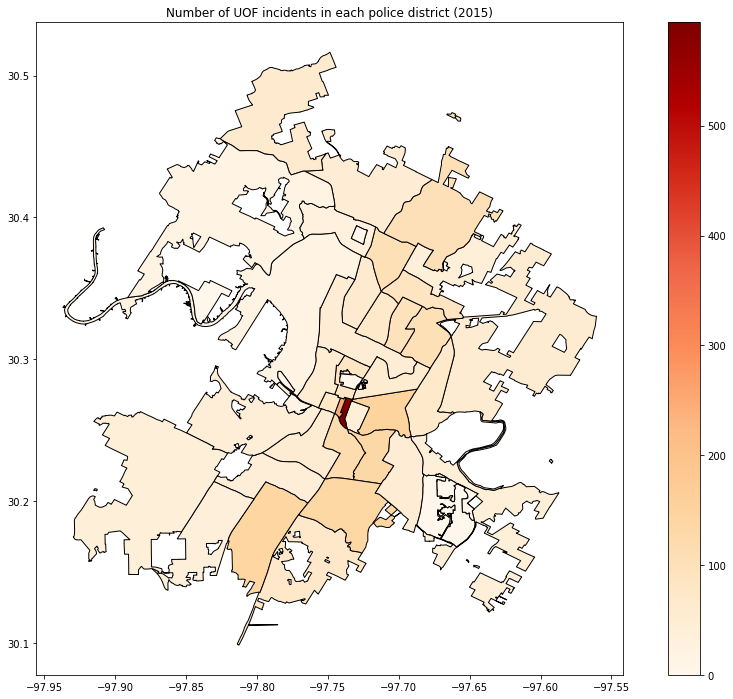

In [247]:
to_plot = districts.copy()
to_plot = to_plot.join(total_incidents)
ax = to_plot.plot(figsize=(16, 12), column='total_incidents', cmap='OrRd', edgecolor='k', legend=True)
ax.set_title('Number of UOF incidents in each police district (2015)');

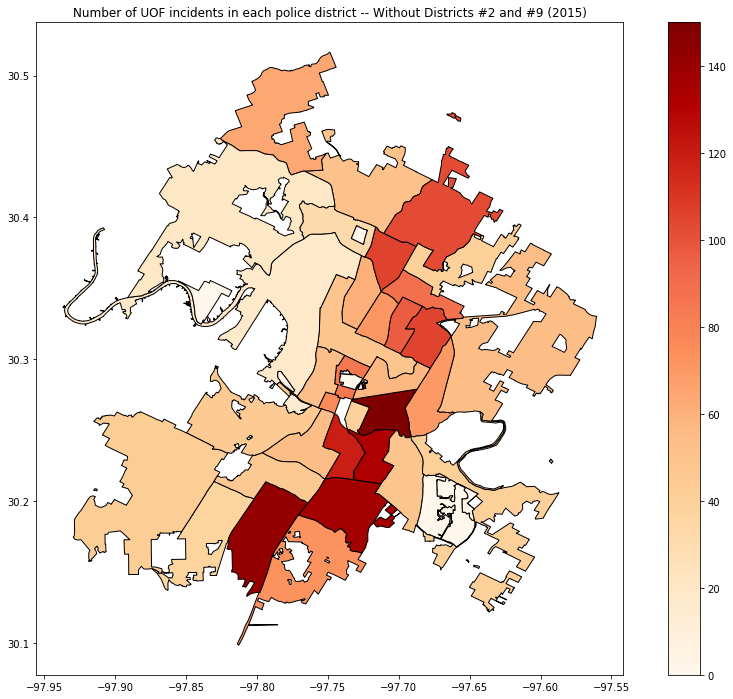

In [254]:
to_plot = districts.copy()
to_plot = to_plot.join(total_incidents)
to_plot = to_plot[to_plot.index != 2]
to_plot = to_plot[to_plot.index != 9]
ax = to_plot.plot(figsize=(16, 12), column='total_incidents', cmap='OrRd', edgecolor='k', legend=True)
ax.set_title('Number of UOF incidents in each police district -- Without Districts #2 and #9 (2015)');